The goal is to learn how to code a diffusion model. I'll use the following paper: https://arxiv.org/abs/2011.13456.

The only real assumption which we make is that we have access to data which follows some distribution. The goal is to sample from this distribution.

The basic idea is as follows. Given a (vector-valued) probability distribution, we can define a stochastic process whose initial conditions are sampled according to this distribution, and whose evolution is governed by the SDE
$$
dx = f(x, t)\, dt + g(t) \,dw,
$$
where $w$ is a standard Brownian motion and time ranges from $0$ to $T$. One can consider the case where $f$ and $g$ are matrix-valued and are both allowed to depend on $x$ as well as $t$, but we will just need the scalar case. If the marginal density of this stochastic process at time $t$ is given by $p_t$, then one can show that the time-reversal of this process also follows a (backwards-time) SDE:
$$
dx = (f(x, t) - g^2(t) \nabla_x \log p_t(x) )\,dt + g(t) \,d \overline w,
$$
where $\overline w$ is a Brownian motion when time runs backwards. The conclusion of this is that, if you know $f, g, \nabla_x \log p_t(x)$, and $p_T$, then you can numerically simulate the backwards SDE to sample from $p_0$. Typically, the setup is such that $p_0$ is the distribution we wish to sample from and $p_T$ is known and easy to sample from. This is usually accomplished by choosing $f$ and $g$ such that the evolution of the forward SDE converges to (at least very close to) a standard Gaussian, regardless of the initial condition. This leaves $\nabla_x \log p_t(x)$ (for all $t$) as the only unknown piece of the puzzle. This is the so-called score function, which is the critical ingredient needed to sample from the backwards SDE.

There is also an associated probability flow ODE which has the property that, if the initial conditions are chosen according to $p_0$, then the marginal distributions of the process at time $t$ exactly match the marginal distributions of the SDE at time $t$, although the trajectories are different. So by sampling from $p_T$ and simulating the ODE backwards (which requires no more work than simulating it forwards), once can sample from $p_0$. The ODE is given by
$$
dx = (f(x, t) - g^2(t) \nabla_x \log p_t(x) )\,dt.
$$
Again, the only missing ingredient is the score function $\nabla_x \log p_t(x)$.

From this, we see that, apart from choosing $f$ and $g$, there are essentially two steps to training and doing inference with a diffusion model: learning the score function, and numerically solving either an SDE or ODE.

The typical machine learning approach is to use a neural network $s_\theta(x, t)$ to approximate $\nabla_x \log p_t(x)$. The neural network must be a function of $x$ and $t$, as the score function is, and is parameterized by $\theta$. The loss function is going to be weighted sum of
$$
\| s_\theta(x, t)- \nabla_x \log p_t(x)\|^2
$$
evaluated at various choices of $x$ and $t$ (the norm is the $L^2$ norm, so this is the sum of squared errors). The exact weighting and choice of evaluation points can be considered a hyperparameter. It's also worth noting that $x$ and $t$ must be chosen in a way that makes evaluating $\nabla_x \log p_t(x)$ relatively easy. Indeed, it certainly must be difficult to evaluate it at arbitrary $x$ and $t$: if this were easy, there would be no need to learn a function $s_\theta(x, t)$ approximating it.

In general, working with the marginal density $p_t(x)$ is intractable, but the *conditional* marginal density, conditioned on initial value $x(0)$ of the SDE, may be easy to work with. We denote the conditional marginal density at time $t$, conditioned on the initial value $x(0)$, as $p_{0t}(x|x(0))$. In other words, $p_{0t}$ is the *transition kernel* from time $0$ to time $t$ of the stochastic process. If the choice of $f$ and $g$ are sufficiently nice, then this conditional marginal density is that of a Gaussian distribution whose mean and variance are a function of $x(0)$ and $t$. And the gradient of the log of this density is very easy to work with. 

I don't understand exactly the reasoning for the following. For fixed $t$, we want to minimize $\mathbb E_{p_t(x)} \, \| s_\theta(x, t)- \nabla_x \log p_t(x)\|^2$, where the notation $\mathbb E_{p_t(x)}$ means taking the expectation when $x$ is distributed according to $p_t(x)$. Since we know how to work with $p_{0t}(x | x(0))$ but not $p_t(x)$, we can instead minimize 
$$
\mathbb E_{p_0(x)} \mathbb E_{p_{0t}(x | x(0))} \, \| s_\theta(x, t)- \nabla_x \log p_{0t}(x | x(0)) \|^2.
$$
It is not obvious to me why minimizing this expression, where $p_t(x)$ has been replaced by $p_{0t}(x | x(0))$ (and a conditional expectation inserted), is equivalent to minimizing the original. It is, however, obvious that this problem is much more tractable. Lastly, we need to incorporate all time steps, so we can define our loss function as
$$
L(\theta) = \mathbb E_t \lambda(t) \mathbb E_{p_0(x)} \mathbb E_{p_{0t}(x | x(0))} \, \| s_\theta(x, t)- \nabla_x \log p_{0t}(x | x(0)) \|^2,
$$
where $\lambda(t)$ is a nonnegative function which determines the relative weights of the loss at different times, and $\mathbb E_t$ has $t$ uniformly distributed between $0$ and $T$. Of course, we must take these expectations numerically. A simple scheme to do this is to sample $t$ uniformly, sample $x(0)$ from the data, sample $x$ from $p_{0t}(x|x(0))$, and evaluate $\| s_\theta(x, t)- \nabla_x \log p_{0t}(x | x(0)) \|^2$ at this point. Average this over many such samples to get an estimate of $L(\theta)$ which can be used for optimization. The paper says that it is typical to choose $\lambda(t)$ to be inversely proportional to $\mathbb E \| \nabla_x \log p_{0t}(x(t) | x(0))\|^2$.

Up to this point, things have been completely general. Let's choose specific hyperparameters so that we can simplify things further. Notably, we need to know $\nabla_x \log p_{0t}(x | x(0))$ to be able to do anything. We set $T=1$, so that $t$ ranges from $0$ to $1$, and we make the following choice of $f$ and $g$:
\begin{align*}
f(x, t) &= \beta(t),\\
g(t) &= \sqrt{\beta(t)},\\
\end{align*}
This is the continuous-time analog of the discrete-time *denoising diffusion probabilistic modeling* (DDPM) approach. It remains to choose $\beta(t)$. We choose 
$$\beta(t) = \beta_\text{min} + t(\beta_\text{max} - \beta_\text{min}).$$
So $\beta(t)$ moves linearly from $\beta_\text{min}$ to $\beta_\text{max}$. And we will choose $\beta_\text{min}=0.1$, $\beta_\text{max}=20$. These are simply the choices made in the paper I am following, and I do not have any extra insight as to why these choices are are made. The main paper gives the following reference for how the mean and variance of the transition kernel can be computed: Applied stochastic differential equations, volume 10, by Simo Sarkka and Arno Solin.
We can obtain the following transition kernels: $p_{0t}(x|x(0))$ is a Gaussian distribution with mean and variance 
\begin{align*}
\mu(x(0), t) &= x(0) \, \exp\left(-\frac 1 4 t^2 (\beta_\text{max}-\beta_\text{min}) - \frac 1 2 t \beta_\text{min}\right), \\
\sigma(x(0), t)^2 &= 1 - \exp \left(-\frac 1 2 t^2 (\beta_\text{max}-\beta_\text{min}) - t \beta_\text{min}  \right).
\end{align*}
Perhaps it is more proper to say that the variance is $\sigma(x(0), t)^2 \mathbf I$, i.e., every component of the distribution is independent with variance $\sigma(x(0), t)$. In any case, letting $k$ be the number of components, the density of a multivariate gaussian with mean $\mu$ and independent components each having variance $\sigma^2$ is given by
$$
(2 \pi)^{-k/2} \sigma^{-k} \exp \left(- \frac{\|x - \mu \|^2}{2 \sigma^2} \right).
$$
Taking the log and then gradient (with respect to $x$) of this, we get 
$$
-(x-\mu)/\sigma^2.
$$
So we see that 
\begin{align*}
\nabla_x \log(p_{0t}(x | x(0))) &= (\mu(x(0), t) - x)/\sigma(x(0), t)^2\\
 &= \frac{ x(0) \exp\left(-\frac 1 4 t^2 (\beta_\text{max}-\beta_\text{min}) - \frac 1 2 t \beta_\text{min}\right) - x}{1 - \exp \left(-\frac 1 2 t^2 (\beta_\text{max}-\beta_\text{min}) - t \beta_\text{min}  \right)}\\
 &= \frac{x(0) e^{-\alpha(t)/2}-x}{1-e^{-\alpha(t)}},
\end{align*}
for $\alpha(t) = \frac 1 2 t^2 (\beta_\text{max}-\beta_\text{min}) + t \beta_\text{min}$.

Lastly, we need $\lambda(t)$. We can compute 
\begin{align*}
\mathbb E \left\| \nabla_x \log p_{0t}(x(t) | x(0))\right\|^2
&= \mathbb E \left\| \frac{x(t) - \mu(x(0), t)}{\sigma(t)^2} \right\|^2\\
&= \frac{1}{\sigma(t)^2} \mathbb E \,  \mathbb E \left[ \,\left\lVert \frac{x(t) - \mu(x(0), t)}{\sigma(t)}  \right\rVert^2  \Bigr| \, x(0) \right]. 
\end{align*}
Conditional on $x(0)$, $x(t)$ follows a multivariate normal distribution with mean $\mu(x(0), t)$ and standard deviation $\sigma(t)$, so subtracting the mean and dividing by the standard deviation gives a standard multivariate normal. Taking the squared norm gives a chi-squared distribution, and the expectation becomes equal to the number of dimensions, which is a constant. Since we want $\lambda(t)$ to be inversely proportional to the expression, we can ignore the constant, and are left with
$$
\lambda(t) = \sigma(t)^2.
$$

At this point, we have everything we need for our loss function and, thus, everything to train a neural network to approximate the score function.

Before we actually implement things, though, it's important to note that there are some issues when $t$ is very close to $0$. The root of the issue is that we do not actually have access to $p(0)$, but only a finite number of samples from it. When we approximate $\mathbb E_{p_0(x)}$ by sampling from our dataset, what we are actually doing is replacing $p(0)$ by an average of delta distributions located at the points in our dataset. When as $t$ goes to $0$, the density $p_t$ becomes spiky, with spikes at the data points that blow up as $t$ goes to $0$. And the transition kernel $p_{0t}(x | x(0))$ also blows up, making its log gradient difficult to work with. To get around this, one can simply choose a small number $\varepsilon$ and restrict all computation to $t \in [\varepsilon, 1]$, and sample from $p_\varepsilon$ instead of $p_0$. A choice of $\varepsilon = 10^{-5}$ is made for training, and $\varepsilon = 10^{-3}$ for sampling (these numbers are again copied from the paper). 

We can make a brief plan of the things to be implemented. For the toy example, we need data. An easy option is to just use a mixture of Gaussians. We'll make a abstract data generator class for this and subclass a Gaussian mixture data generator. We'll use the PyTorch built-in `dataset` and/or `dataloader` classes for feeding our training data to the model. For the model, we'll need a neural network which will approximate our score function, a choice of $f$ and $g$, and a way to train the model. We can make a class for the score function neural network. Another class can deal with $f, g, \beta_\text{min}, \beta_\text{max}$, and $\nabla_x \log(p_{0t}(x | x(0)))$, and the model trainer can be a class. Finally, we'll need a numerical ODE/SDE solver which can take the trained score function and generate samples.

We start with the data generation.

In [1]:
import torch
from abc import ABC # abstract base class
import abc
import numpy as np
from torch import nn
from torch.utils.data import Dataset
from typing import Type
from typing import Callable

In [2]:
class DataGenerator(ABC):
    @abc.abstractmethod
    def generate_sample(self):
        raise NotImplementedError

class GaussianMixtureGenerator(DataGenerator):
    def __init__(self, num_dims, weights, means, covariances):
        self.num_dims = num_dims
        self.num_gaussians = len(weights)
        self.indexes = list(range(self.num_gaussians))
        self.weights = weights
        self.means = means
        self.covariances = covariances
        assert(len(means) == self.num_gaussians)
        assert(len(covariances) == self.num_gaussians)

    def generate_sample(self):
        mixture_class = np.random.choice(self.indexes, p=self.weights)
        return np.random.multivariate_normal(mean=self.means[mixture_class], cov=self.covariances[mixture_class])

Next, our neural network for the score function. Remember that the score function is a function with $x$ and $t$ as inputs, and a vector (with the dimensions of $x$) as output.

In [3]:
class ScoreModel(nn.Module):
    def __init__(self, num_dims: int, num_hidden_layers: int, hidden_layer_size: int, activation: Type[nn.Module]=nn.ReLU):
        super().__init__()
        self.num_dims = num_dims
        self.num_hidden_layers = num_hidden_layers
        assert (num_hidden_layers >= 1) # require a hidden layer
        self.hidden_layer_size = hidden_layer_size
        self.activation = activation() # an instance of the class
        self.first_layer = nn.Linear(in_features=num_dims+1, # an extra time dimension
                                     out_features=hidden_layer_size)
        self.inner_layers = [nn.Linear(hidden_layer_size, hidden_layer_size)
                             for _ in range(num_hidden_layers-1)]
        self.final_layer = nn.Linear(in_features=hidden_layer_size,
                                     out_features=num_dims)

    def forward(self, x, t): # remember that x and t have shape (batch, dim) and (batch, 1)
        input = torch.cat((x, t), dim=1)
        out = self.first_layer(input)
        out = self.activation(out)
        for layer in self.inner_layers:
            out = layer(out)
            out = self.activation(out)
        return self.final_layer(out)       

Next, we implement the class which holds $f$, $g$, and related values which are necessary for training. We'll call such choices *noise schemes*. They control how the noise added to the data. We make the assumption that time goes from $0$ to $1$. We implement the continuous analog of the DDPM (denoising diffusion probabilistic modeling) noise scheme. Remember that DDPM has $f(x, t) = \beta(t)$ and $g(t) = \sqrt{\beta(t)}$. A linear choice of $\beta(t)$ is $\beta(t) = \beta_\text{min} + t(\beta_\text{max} - \beta_\text{min})$. This gives $\nabla_x \log(p_{0t}(x | x(0))) = -\frac{x(0) e^{-\alpha(t)/2}-x}{1-e^{-\alpha(t)}}$ for $\alpha(t) = \frac 1 2 t^2 (\beta_\text{max}-\beta_\text{min}) + t \beta_\text{min}$.

In [4]:
class NoiseScheme(ABC):
    @abc.abstractmethod
    def f(self, x, t):
        raise NotImplementedError
    
    @abc.abstractmethod
    def g(self, x, t):
        raise NotImplementedError
    
    @abc.abstractmethod
    def conditional_log_gradient(self, x, t, x_0):
        raise NotImplementedError
    
    @abc.abstractmethod
    def generate_noised_sample(self, t, x_0):
        raise NotImplementedError
    
    @abc.abstractmethod
    def time_weight(self, t):
        raise NotImplementedError
    
class LinearDDPMNoiseScheme(NoiseScheme):
    def __init__(self, beta_min=0.1, beta_max=20):
        self.beta_min = beta_min
        self.beta_max = beta_max

    def beta(self, t):
        return self.beta_min + t*(self.beta_max - self.beta_min)

    def f(self, x, t):
        return self.beta(t)

    def g(self, x, t):
        return torch.sqrt(self.beta(t))
    
    def alpha(self, t):
        return 1/2*torch.square(t)*(self.beta_max - self.beta_min) + t*self.beta_min

    def conditional_mean(self, t, x_0):
        return x_0*torch.exp(-self.alpha(t)/2)

    def conditional_variance(self, t):
        return 1-torch.exp(-self.alpha(t))
    
    def conditional_log_gradient(self, x, t, x_0):
        return (self.conditional_mean(t, x_0) - x)/self.conditional_variance(t)
    
    def generate_noised_sample(self, t, x_0):
        var = self.conditional_variance(t) # shape is (batch, 1)
        std = torch.sqrt(var)
        std = std.expand(x_0.size())  # expands to (batch, dim)
        mean = self.conditional_mean(t, x_0) # shape is (batch, dim)
        return torch.normal(mean, std)
    
    def time_weight(self, t):
        return self.conditional_variance(t)

Now, a trainer class. A trainer will need to be able to take in data, an untrained score neural network, and a noise scheme and train the neural network on these.

In [28]:
class DiffusionTrainer:
    def __init__(self, 
                 score: ScoreModel,
                 noise_scheme: NoiseScheme, 
                 train_dataset: Dataset,
                 train_epsilon=0.00001,
                 optimizer: Type[torch.optim.Optimizer]=torch.optim.Adam, # should take a class, not an instance
                 batch_size=32,
                 epochs=1000,
                 ) -> None:
        self.score = score
        self.noise_scheme = noise_scheme
        self.train_dataset = train_dataset
        self.dataloader = torch.utils.data.DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        self.train_epsilon = train_epsilon
        self.optimizer = optimizer(params=self.score.parameters(), lr=0.00001) # an instance
        self.mse = nn.MSELoss(reduction='none')
        self.loss_history = []
        self.batch_size = batch_size
        self.epochs = epochs

    def train_one_batch(self, t, batch, noised_batch) -> float:
        # returns batch loss
        predicted_scores = self.score(x=noised_batch, t=t)
        conditional_scores = self.noise_scheme.conditional_log_gradient(x=noised_batch, t=t, x_0=batch)
        losses = self.noise_scheme.time_weight(t)*self.mse(predicted_scores, conditional_scores).sum(dim=1)
        loss = losses.mean()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def train_one_epoch(self) -> None:
        epoch_loss_history = []
        for batch in self.dataloader:
            batch = batch[0] # batch is a list of length 1 whose element is what we actually want
            # add noise
            batch_size = batch.size(dim=0)
            # uniform time between train_eps and 1
            t = torch.rand(batch_size, 1)*(1-self.train_epsilon) + self.train_epsilon
            noised_batch = self.noise_scheme.generate_noised_sample(t=t, x_0=batch)
            batch_loss = self.train_one_batch(t, batch, noised_batch)
            epoch_loss_history.append(batch_loss)
        
        self.loss_history.append(torch.mean(torch.Tensor(epoch_loss_history)))

    def train(self) -> None:
        for epoch in range(self.epochs):
            self.train_one_epoch()
            print(f'Epoch {epoch+1:3d}, loss {self.loss_history[-1]:.2f}')

Finally, we need some sort of numerical integrator to solve the ODE/SDE. Here, I implement a very basic Euler method for the probability flow ODE. Remember that the ODE is given by 
$$
dx = (f(x, t) - g^2(t) \nabla_x \log p_t(x) )\,dt.
$$
This ODE will be simulated backwards for sampling, starting at time 1, and going to time 0.

In [6]:
class EulerODESampler: # numerically integrates
    def __init__(self, score: ScoreModel, noise_scheme: NoiseScheme, sample_epsilon=0.001, num_steps=30):
        self.score = score
        self.num_dims = self.score.num_dims
        self.noise_scheme = noise_scheme
        self.sample_epsilon = sample_epsilon
        self.num_steps = num_steps
        self.step_size = (1-sample_epsilon)/num_steps
        self.times = torch.linspace(
            start=1, end=self.sample_epsilon, steps=self.num_steps+1)
        # exclude the last time since linspace includes both endpoints
        self.times = self.times[:-1]
        # each time should have shape (1, 1)
        self.times = self.times.reshape(self.num_steps, 1, 1)


    def generate_latent(self):
        return torch.normal(mean=torch.zeros(1, self.num_dims),
                             std=torch.ones(1, self.num_dims))
        
    def step(self, x, t) -> torch.Tensor:
        # returns x at the next time step (stepping backwards in time)
        gradient = self.noise_scheme.f(x, t) - torch.square(self.noise_scheme.g(x, t))*self.score(x, t)
        return x - self.step_size*gradient

    def generate_sample(self):
        x = self.generate_latent()
        for t in self.times:
            x = self.step(x, t)
        return x

In [37]:
# TESTING that things don't raise errors. Some testing library would be better but this is fine.

# testing data generator
num_dims=2
num_classes=4
num_datapoints = 32*1000
identity_covariance = np.identity(num_dims)
covariances = [identity_covariance]*num_classes
means = [(0, 0), (5, 0), (0, 3), (2, -3)]
weights = [.3, .1, .25, .35]
data_generator = GaussianMixtureGenerator(
    num_dims=num_dims, weights=weights, means=means, covariances=covariances)

data_sample = data_generator.generate_sample()
data_np = np.array([data_generator.generate_sample() for _ in range(num_datapoints)])
data = torch.Tensor(data_np)

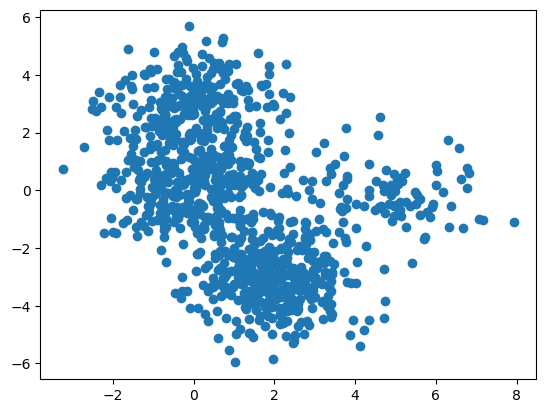

In [26]:
from matplotlib import pyplot as plt
data_x = data_np[:1000, 0]
data_y = data_np[:1000, 1]
plt.scatter(data_x, data_y)

In [38]:
# testing score model
score = ScoreModel(num_dims=num_dims, num_hidden_layers=2, hidden_layer_size=30, activation=torch.nn.ReLU)
x = torch.Tensor([
    [1.3, 2]
])
t = torch.Tensor([
    [.5]
])
score(x, t)

# testing noise scheme
x_0 = torch.zeros_like(x)
noise_scheme = LinearDDPMNoiseScheme()
noise_scheme.f(x, t)
noise_scheme.g(x, t)
noise_scheme.conditional_log_gradient(x, t, x_0)
noise_scheme.generate_noised_sample(t, x_0)
noise_scheme.time_weight(t)

# testing the trainer
dataset = torch.utils.data.dataset.TensorDataset(data)
trainer = DiffusionTrainer(score=score,
                           noise_scheme=noise_scheme,
                           train_dataset=dataset,
                           epochs=1000,
                           train_epsilon=0.01)

trainer.train()

Epoch   1, loss 11.37
Epoch   2, loss 10.86
Epoch   3, loss 10.70
Epoch   4, loss 10.64
Epoch   5, loss 11.08
Epoch   6, loss 10.92
Epoch   7, loss 11.19
Epoch   8, loss 11.43
Epoch   9, loss 10.49
Epoch  10, loss 10.96
Epoch  11, loss 10.24
Epoch  12, loss 11.00
Epoch  13, loss 10.94
Epoch  14, loss 10.59
Epoch  15, loss 10.63
Epoch  16, loss 10.82
Epoch  17, loss 10.22
Epoch  18, loss 10.75
Epoch  19, loss 10.75
Epoch  20, loss 10.34
Epoch  21, loss 10.28
Epoch  22, loss 10.84
Epoch  23, loss 10.46
Epoch  24, loss 10.25
Epoch  25, loss 10.55
Epoch  26, loss 10.51
Epoch  27, loss 10.47
Epoch  28, loss 10.35
Epoch  29, loss 10.86
Epoch  30, loss 10.59
Epoch  31, loss 10.95
Epoch  32, loss 10.02
Epoch  33, loss 10.50
Epoch  34, loss 10.42
Epoch  35, loss 10.22
Epoch  36, loss 10.19
Epoch  37, loss 10.28
Epoch  38, loss 10.24
Epoch  39, loss 10.18
Epoch  40, loss 10.46
Epoch  41, loss 10.43
Epoch  42, loss 10.05
Epoch  43, loss 10.31
Epoch  44, loss 9.98
Epoch  45, loss 10.36
Epoch  46, 

In [39]:
# Test the ODE sampler
sampler = EulerODESampler(score, noise_scheme, sample_epsilon=.01)
sampler.generate_sample()
samples = np.array([sampler.generate_sample().detach().numpy() for _ in range(1000)])

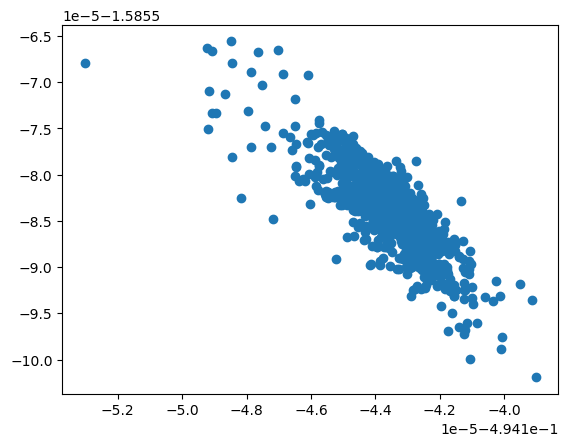

In [40]:
# plot some samples
from matplotlib import pyplot as plt
samples.shape
x = samples[:, :, 0].reshape(1000)
y = samples[:, :, 1].reshape(1000)
plt.scatter(x=x, y=y)